# Demonstration of Features

First let's import everything we need...

In [1]:
import hepconvert
import uproot
import awkward as ak
from hist import Hist
from skhep_testdata import data_path

# Copying ROOT Files with copy_root()

## Simple copy; no modifications
Simple example data:

In [2]:
file = uproot.open(data_path("uproot-simple.root"))
file["tree"].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
one                  | int32_t                  | AsDtype('>i4')
two                  | float                    | AsDtype('>f4')
three                | char*                    | AsStrings()


In [3]:
hepconvert.copy_root("samples/destination.root", data_path("uproot-simple.root"), force=True)

# View result:
copy = uproot.open("samples/destination.root")
copy["tree"].show()
copy.close()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
one                  | int32_t                  | AsDtype('>i4')
two                  | float                    | AsDtype('>f4')
three                | char*                    | AsStrings()


# Branch Slimming

For branch slimming, or removing branches from a TTree, pass branch names using arguments **keep_branches** or **drop_branches**. 
<br>**keep_branches** removes all branches except those selected. 
<br>**drop_branches** removes only the branches selected.

In [6]:
hepconvert.copy_root("samples/destination.root", data_path("uproot-HZZ.root"), keep_branches="Jet_Px", force=True)

# View result:
new = uproot.open("samples/destination.root")
new["events"].show()
new.close()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nJet_Px              | int32_t                  | AsDtype('>i4')
Jet_Px               | float[]                  | AsJagged(AsDtype('>f4'))


# Example of dropping branches

Here we are copying a file while dropping all branches beginning with "Jet." Branches can be selected using any wildcarding supported by Uproot's "filter_branches" argument.

In [7]:
hepconvert.copy_root("samples/destination.root", data_path("uproot-HZZ.root"), drop_branches="Jet_*", force=True)

# View result:
new = uproot.open("samples/destination.root")
new["events"].show()
new.close()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
MET_px               | float                    | AsDtype('>f4')
MET_py               | float                    | AsDtype('>f4')
MChadronicBottom_px  | float                    | AsDtype('>f4')
MChadronicBottom_py  | float                    | AsDtype('>f4')
MChadronicBottom_pz  | float                    | AsDtype('>f4')
MCleptonicBottom_px  | float                    | AsDtype('>f4')
MCleptonicBottom_py  | float                    | AsDtype('>f4')
MCleptonicBottom_pz  | float                    | AsDtype('>f4')
MChadronicWDecayQ... | float                    | AsDtype('>f4')
MChadronicWDecayQ... | float                    | AsDtype('>f4')
MChadronicWDecayQ... | float                    | AsDtype('>f4')
MChadronicWDecayQ... | float                    | AsDtype('>f4')
MChadronicWDecayQ... | float                    | AsDtype(

# Branch Skimming

hepconvert uses Uproot's *cut* and *expressions* arguments for branch skimming. Currently 

In [8]:
hepconvert.copy_root("samples/destination.root", data_path("uproot-HZZ.root"), keep_branches="Jet_*", cut="Jet_Px > 10", force=True)
tree = uproot.open("samples/destination.root")["events"]
print(tree["Jet_Px"].array())
print(tree["Jet_Py"].array())
tree.close()

[[], [], [], [36.6], [], [27.7], [], ..., [34], [], [37.1], [], [], [], []]
[[], [], [], [21.8], [], [-14.5], [], ..., [58.9], [], [20.1], [], [], [], []]


# Sum histograms

Here we will sum histogram data across multiple files and write the summed histogram to a new file. Similar functionality to ROOT's hadd, but this version does not depend on ROOT.

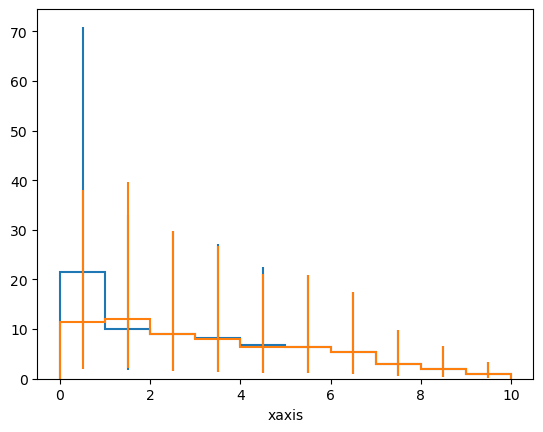

In [9]:
# Example data
f2 = uproot.open("samples/histograms/file2dim1.root")
f2["name"].to_hist().plot()
f2.close()

f1 = uproot.open("samples/histograms/file1dim1.root")
f1["name"].to_hist().plot()
f1.close()

Files summed: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 135.89it/s]


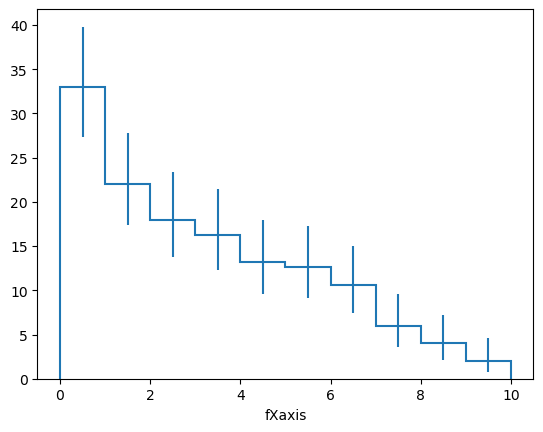

In [10]:
# Sum the histograms, write to file "summed_hists.root"

# Wildcarding and globbing both work for file names
hepconvert.add_histograms("samples/summed_hists.root", "samples/histograms/", progress_bar=True, force=True)

file = uproot.open("samples/summed_hists.root")
file["name"].to_hist().plot()
file.close()

# ROOT <-> Parquet
Now we will convert the uproot-HZZ.root to a Parquet file, and then convert the new Parquet file back to ROOT. 
<br>**Reminder:** currently hepconvert can only write **1 TTree** to a Parquet file, but one could potentially merge multiple TTrees and then write to a Parquet file.
<br>Soon **merge_parquet()** will be implemented, so the reverse will soon be possible. 


## ROOT to Parquet using root_to_parquet()

Now we will convert the uproot-HZZ ROOT file to a Parquet file. If a file has multiple trees, choose one using "tree"

In [11]:
hepconvert.root_to_parquet(
    out_file="samples/uproot-HZZ.parquet",
    in_file=data_path("uproot-HZZ.root"),
    tree="events",   # Specifies the tree to be written
    step_size="100MB", # Step size in entries
    force=True,
)
metadata = ak.metadata_from_parquet("samples/uproot-HZZ.parquet")
print("Number of row-groups:", metadata['num_row_groups'])

from_parquet = ak.from_parquet("samples/uproot-HZZ.parquet")
from_parquet["Jet_Py"]

Number of row-groups: 1


<Array [[], [19.9], [], ..., [10.2, -27.2], []] type='2421 * var * float32'>

In [12]:
# Changing the step size changes 
#  the number of row-groups in the new file
hepconvert.root_to_parquet(
    out_file="samples/uproot-HZZ.parquet",
    in_file=data_path("uproot-HZZ.root"),
    step_size=100,  # Step size in entries
    force=True,
)
metadata = ak.metadata_from_parquet("samples/uproot-HZZ.parquet")
# The ROOT file has ~2400 entries
print("Number of row-groups:", metadata['num_row_groups'])


Number of row-groups: 25


## Parquet to ROOT using parquet_to_root()

Now we will convert the parquet file we just made back to ROOT.
To rename the new TTree, use the "name" parameter. Defaults to "tree."



**Note:** This function is unable avoid the duplicate counter issue; the data used to group branches is not stored in Parquet files.

In [13]:
# Renaming the tree 'events'
hepconvert.parquet_to_root("samples/new-uproot-HZZ.root", "samples/destination.parquet", name="events", progress_bar=True, force=True)

tree = uproot.open("samples/new-uproot-HZZ.root")["events"]
tree.show()
tree.close()

Row-groups written: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.85it/s]

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
NJet                 | int32_t                  | AsDtype('>i4')
nJet_Px              | int32_t                  | AsDtype('>i4')
Jet_Px               | float[]                  | AsJagged(AsDtype('>f4'))
nJet_Py              | int32_t                  | AsDtype('>i4')
Jet_Py               | float[]                  | AsJagged(AsDtype('>f4'))
nJet_Pz              | int32_t                  | AsDtype('>i4')
Jet_Pz               | float[]                  | AsJagged(AsDtype('>f4'))
nJet_E               | int32_t                  | AsDtype('>i4')
Jet_E                | float[]                  | AsJagged(AsDtype('>f4'))
nJet_btag            | int32_t                  | AsDtype('>i4')
Jet_btag             | float[]                  | AsJagged(AsDtype('>f4'))
nJet_ID              | int32_t                  | AsDtype('>i4')
Jet_ID  